In [38]:
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

# read data

In [39]:
words = open('../data/names.txt', 'r').read().splitlines()

In [40]:
len(words)

32033

In [41]:
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [42]:
chars = sorted(list(set(''.join(words))))

# util

In [43]:
itos = {}
itos[0] = '.'
itos |= {i+1: s for i, s in enumerate(chars)}

In [44]:
stoi = {s: i for i, s in itos.items()}

In [45]:
vocab_size = len(stoi)
vocab_size

27

# Build a neural language model

## prepare data

In [46]:
block_size = 8

In [47]:
def build_dataset(data):
    X, Y = [], []
    for w in data[:]:
        # print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            # print(''.join([itos[i] for i in context]), '--->', itos[ix])
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]        

    X = torch.tensor(X)
    Y = torch.tensor(Y)        
    print(X.shape, Y.shape)
    return X, Y

In [48]:
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
         
Xtr, Ytr = build_dataset(words[:n1])
Xdv, Ydv = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])                               

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


# Some Modules

In [70]:
class FlattenConsecutive(nn.Module):
    def __init__(self, n):
        super().__init__()
        self.n = n
        
    def __call__(self, x):
        # print('FlattenConsecutive [steve]', x.shape)        
        B, T, C = x.shape
        x = x.view(B, T//self.n, C*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out    

# ----------------------------------    
class Swap(nn.Module):
    def __init__(self):
        super().__init__()
        
    def __call__(self, x):
        # print('Swap [steve]', x.shape)
        x = x.transpose(1, 2).contiguous()
        self.out = x
        return self.out

# Train a neural language model

## define model

In [78]:
from collections import OrderedDict

In [85]:
n_embd = 10 # 24 # 10
n_hidden = 68 # 128 # 68

model = nn.Sequential(
    nn.Embedding(vocab_size, n_embd),
    # FlattenConsecutive(2), nn.Linear(n_embd * block_size, n_hidden, bias=False), Transpose(), nn.BatchNorm1d(n_hidden), nn.Tanh(),
    # FlattenConsecutive(block_size), nn.Linear(n_embd * block_size, n_hidden, bias=False), nn.BatchNorm1d(n_hidden), nn.Tanh(),
    FlattenConsecutive(2), nn.Linear(n_embd * 2, n_hidden, bias=False), Swap(), nn.BatchNorm1d(n_hidden), Swap(), nn.Tanh(),
    FlattenConsecutive(2), nn.Linear(n_hidden * 2, n_hidden, bias=False), Swap(), nn.BatchNorm1d(n_hidden), Swap(), nn.Tanh(),
    FlattenConsecutive(2), nn.Linear(n_hidden * 2, n_hidden, bias=False), nn.BatchNorm1d(n_hidden), nn.Tanh(),
    nn.Linear(n_hidden, vocab_size),
)

with torch.no_grad():
    model[-1].weight *= 0.02

print(sum(p.nelement() for p in model.parameters()))
# for p in model.parameters():
#     p.requires_grad = True

22397


## train model

In [86]:
batch_size = 32
model.train()

Sequential(
  (0): Embedding(27, 10)
  (1): FlattenConsecutive()
  (2): Linear(in_features=20, out_features=68, bias=False)
  (3): Swap()
  (4): BatchNorm1d(68, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): Swap()
  (6): Tanh()
  (7): FlattenConsecutive()
  (8): Linear(in_features=136, out_features=68, bias=False)
  (9): Swap()
  (10): BatchNorm1d(68, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): Swap()
  (12): Tanh()
  (13): FlattenConsecutive()
  (14): Linear(in_features=136, out_features=68, bias=False)
  (15): BatchNorm1d(68, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (16): Tanh()
  (17): Linear(in_features=68, out_features=27, bias=True)
)

In [88]:
# optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

In [89]:
loglossi = []
lossi = []
STEPS = 200_000
# STEPS = 2_000
for i in tqdm(range(STEPS)):
    # mini-batch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    # forward
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)

    # backward
    # optimizer.zero_grad(set_to_none=True)
    for p in model.parameters():
        p.grad = None
    loss.backward()

    # update
    # optimizer.step()
    lr = 0.1 if i < STEPS//2 else 0.01
    for p in model.parameters():
        p.data += -lr * p.grad
    
    # tracking
    loglossi.append(loss.log10().item())
    lossi.append(loss.item())
    
    # break
    if i >= 10999:
        # break
        pass

100%|█████████████████████████████████████████████████████████| 200000/200000 [04:37<00:00, 721.25it/s]


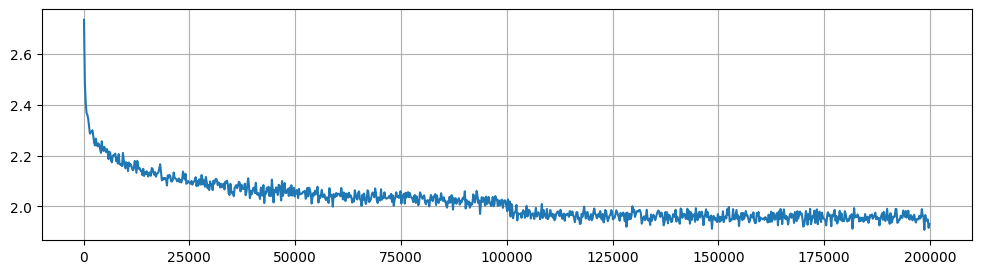

In [90]:
group_size = 200
plt.figure(figsize=(12,3))
plt.plot(
    torch.arange(len(lossi)).view(-1, group_size).float().mean(1),
    torch.tensor(lossi).view(-1, group_size).mean(1)
)
plt.grid()
plt.show()

## compute loss on train/dev/test

In [91]:
model.eval()

Sequential(
  (0): Embedding(27, 10)
  (1): FlattenConsecutive()
  (2): Linear(in_features=20, out_features=68, bias=False)
  (3): Swap()
  (4): BatchNorm1d(68, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): Swap()
  (6): Tanh()
  (7): FlattenConsecutive()
  (8): Linear(in_features=136, out_features=68, bias=False)
  (9): Swap()
  (10): BatchNorm1d(68, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): Swap()
  (12): Tanh()
  (13): FlattenConsecutive()
  (14): Linear(in_features=136, out_features=68, bias=False)
  (15): BatchNorm1d(68, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (16): Tanh()
  (17): Linear(in_features=68, out_features=27, bias=True)
)

In [92]:
def eval_dataset(X, Y):
    with torch.no_grad():
        logits = model(X)
        loss = F.cross_entropy(logits, Y)
        print(loss.item())

In [57]:
eval_dataset(Xtr, Ytr)
eval_dataset(Xdv, Ydv)
# eval_dataset(Xte, Yte)

1.9205366373062134
2.020819902420044


In [93]:
eval_dataset(Xtr, Ytr)
eval_dataset(Xdv, Ydv)
# eval_dataset(Xte, Yte)

1.9232821464538574
2.0225183963775635


# Q1: How to get rid of `Swap'?